In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.1.0


In [29]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
    

In [14]:
#column_names = ['WC','CH01', 'CH02', 'CH03', 'CH04', 'CH05']


raw_dataset = pd.read_csv('d:/train.csv', na_values="?", comment='\t', sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()

dataset.tail()


,wc,ch1,ch2,ch3,ch4,ch5
254,42.303059,4660.761230,157.366135,3377.354004,377.024536,54.971466
255,42.271137,4765.643555,166.077011,3498.130615,393.722290,57.608063
256,42.200275,4867.181152,183.892075,3618.986816,413.090302,70.299973
257,42.035328,5070.843750,203.856552,3823.789063,440.576233,84.590729
258,42.118908,4437.041016,126.561356,3111.499756,335.747406,35.723278


In [15]:
dataset.isna().sum()

wc     0
ch1    0
ch2    0
ch3    0
ch4    0
ch5    0
dtype: int64

In [16]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset  = dataset.drop(train_dataset.index)

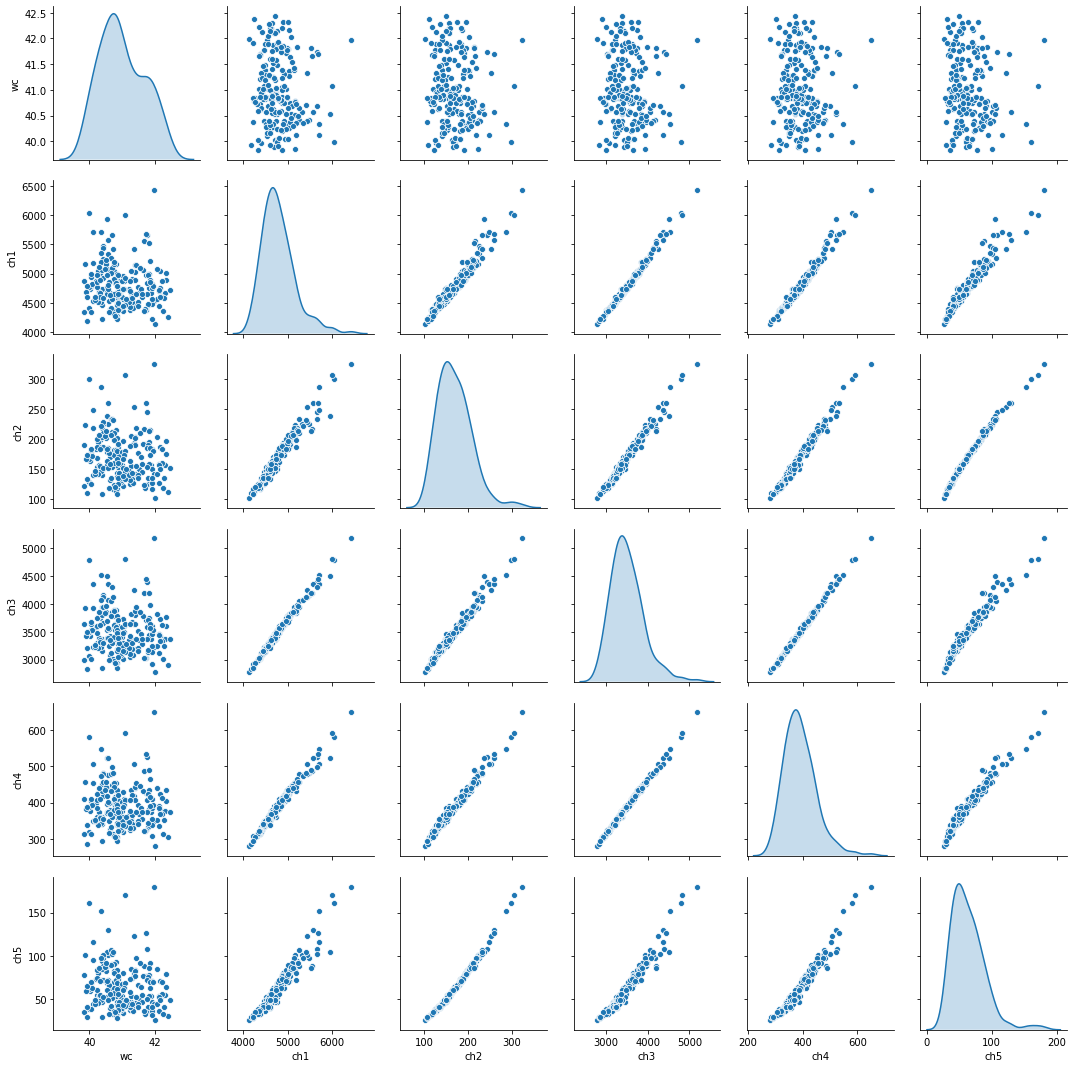

In [17]:
sns.pairplot(train_dataset[["wc","ch1", "ch2", "ch3", "ch4", "ch5"]], diag_kind="kde")

In [18]:
train_stats = train_dataset.describe()
train_stats.pop("wc")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ch1,207.0,4798.885509,372.210915,4140.783203,4550.190430,4737.816895,4985.455322,6424.346191
ch2,207.0,170.520469,38.523544,102.144928,141.374077,165.300797,192.148697,324.534912
ch3,207.0,3511.236093,391.782287,2780.603271,3232.228759,3453.348877,3726.523193,5178.884277
ch4,207.0,391.355375,58.579518,280.664887,349.182663,382.808899,423.128738,648.451843
ch5,207.0,64.031315,25.646511,26.038366,45.285177,59.738178,77.024822,180.055771


In [19]:
train_labels = train_dataset.pop('wc')
test_labels  = test_dataset.pop('wc')

In [20]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data  = norm(test_dataset)


In [21]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae','mse'])
    return model


In [23]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [24]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.19857565],
       [ 0.18100536],
       [ 0.4966969 ],
       [ 0.13762352],
       [ 0.8113915 ],
       [ 0.00582023],
       [ 0.18535423],
       [ 0.5793232 ],
       [ 0.09444211],
       [-0.00591696]], dtype=float32)

In [30]:
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split= 0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1637.6934,  mae:40.4610,  mse:1637.6934,  val_loss:1606.6041,  val_mae:40.0719,  val_mse:1606.6041,  
....................................................................................................
Epoch: 100, loss:0.4289,  mae:0.5223,  mse:0.4289,  val_loss:0.3065,  val_mae:0.4586,  val_mse:0.3065,  
....................................................................................................
Epoch: 200, loss:0.3685,  mae:0.4839,  mse:0.3685,  val_loss:0.3409,  val_mae:0.4371,  val_mse:0.3409,  
....................................................................................................
Epoch: 300, loss:0.5184,  mae:0.5870,  mse:0.5184,  val_loss:0.4496,  val_mae:0.5207,  val_mse:0.4496,  
....................................................................................................
Epoch: 400, loss:0.4253,  mae:0.5217,  mse:0.4253,  val_loss:0.4959,  val_mae:0.6032,  val_mse:0.4959,  
..........................................................

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.404368,0.528353,0.404368,0.459300,0.535518,0.459300,995
996,0.596795,0.639781,0.596795,0.322197,0.477883,0.322197,996
997,0.297988,0.446918,0.297988,0.323250,0.480688,0.323250,997
998,0.363010,0.493170,0.363010,0.398475,0.541522,0.398475,998
999,0.359198,0.477030,0.359198,0.689510,0.711792,0.689510,999


In [32]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE[wc]')

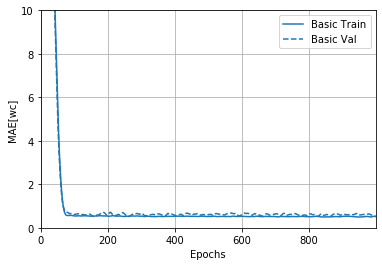

In [34]:
plotter.plot({'Basic':history}, metric="mae")
plt.ylim([0,10])
plt.ylabel('MAE[wc]')

Text(0, 0.5, 'MSE[wc^2]')

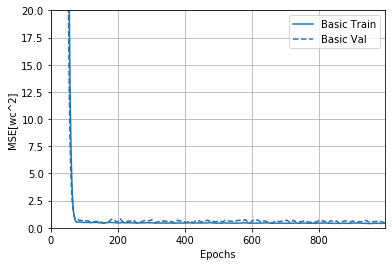

In [35]:
plotter.plot({'Basic':history}, metric="mse")
plt.ylim([0,20])
plt.ylabel('MSE[wc^2]')

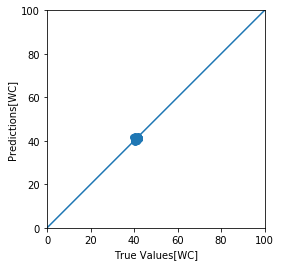

In [40]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values[WC]')
plt.ylabel('Predictions[WC]')
lims = [0,100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [101]:
print(model.predict(normed_test_data[:1]))

print((normed_test_data.iloc[9,:]).shape)

(normed_test_data[:1]).shape

[[40.867134]]
(5,)


(1, 5)

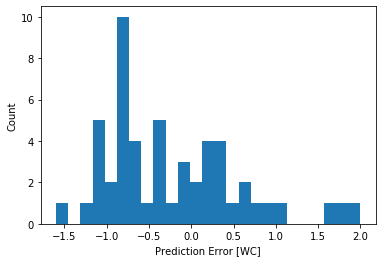

In [38]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [WC]")
_ = plt.ylabel("Count")